# Reading images

[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/ome/EMBL-EBI-imaging-course-05-2023/blob/main/Day_4/Reading_images.ipynb)

## Learning Objectives

* Read local images in Python
* Read remote images stored in the Image Data Resource



## Launch

This notebook uses the [environment_cellpose.yml](./workshop.ipynb) file.

See [Setup](./workshop.ipynb).

### Install dependencies if required

The cell below will install dependencies if you choose to run the notebook in [Google Colab](https://colab.research.google.com/notebooks/intro.ipynb#recent=true). Running the cell could take some time due to the installation of one the dependencies required by ``omero-py``. **Do not run the cell if you are not running the notebook on Google Colab**.


If using Google Colab, **do not** use the ``Runtime>Run all`` entry.

In [ ]:
# Package required to interact with IDR or OMERO
%pip install omero-py==5.13.1

## Read local image using Python

We read a local Tiff image using ``scikit-image``.

In [1]:
import skimage.io as skio

In [2]:
image_local = skio.imread("includes/B4_C3.tif", plugin="tifffile")

In [3]:
print(image_local.shape)

(257, 2, 210, 253)


In [4]:
import matplotlib.pyplot as plt
%matplotlib inline
from ipywidgets import *

def update(z=0):
    c = 1
    fig = plt.figure(figsize=(10, 10))
    plt.imshow(image_local[z, c, :, :])
    plt.tight_layout()
    fig.canvas.flush_events()

interact(update, z= widgets.IntSlider(value=1, min=0, max=image_local.shape[0]-1, step=1, description="Select Z", continuous_update=False))


interactive(children=(IntSlider(value=1, continuous_update=False, description='Select Z', max=256), Output()),…

<function __main__.update(z=0)>

## Read  image stored in [IDR](https://idr.openmicroscopy.org/)

### Download data

You can download the original data using [Aspera](https://www.ibm.com/products/aspera)
See https://idr.openmicroscopy.org/about/download.html for more details

* If the images are in a "common" format e.g. ``TIFF``, it is fairly straightforward as seen above to view them
* If not e.g. ``klb``, a specific reader will be required. This could prove problematic depending the programming language you wish to use for your analysis.

### First connect to IDR

This is the first step to any action when using the Python API.

In [6]:
from omero.gateway import BlitzGateway
HOST = 'ws://idr.openmicroscopy.org/omero-ws'
conn = BlitzGateway('public', 'public',
                    host=HOST, secure=True)
print(conn.connect())
conn.c.enableKeepAlive(60)

True


### Select the image to view

The image is retrieved using its ID.

In [7]:
image_id = 6001247

## Load an image

We load information about the image but **not** the binary data. An image is a 5D-object (XYZCT).

In [8]:
image = conn.getObject("Image", image_id)
print(image.getName())

B4_C3.tif


In [9]:
print("SizeZ: %s, SizeC: %s, Size X: %s, Size Y: %s" % (image.getSizeZ(), image.getSizeC(), image.getSizeX(), image.getSizeY()))

SizeZ: 257, SizeC: 2, Size X: 253, Size Y: 210


## Load the binary data

To access the binary data, we need to load the `pixels` object from the image and retrieve the plane(s).

When using the API, you can selectively load only the planes you need for your analysis. This is an advantage when using analytical tools requiring planar data, e.g. CellProfiler.

Loading one plane at a time

In [10]:
pixels = image.getPrimaryPixels()
z = 0
c = 1
t = 0
plane = pixels.getPlane(z, c, t)

In [11]:
print(plane.shape)

(210, 253)


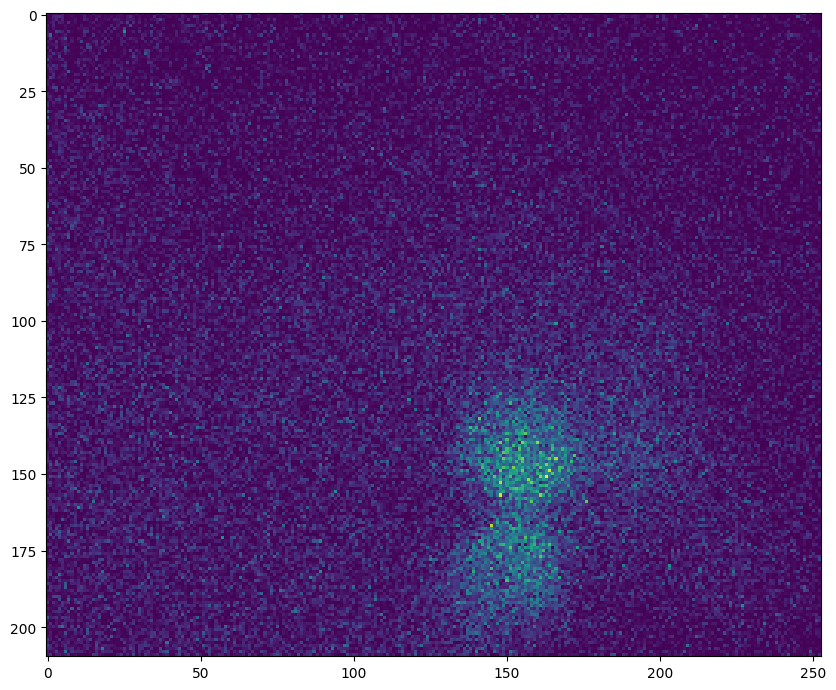

In [12]:
import matplotlib.pyplot as plt
%matplotlib inline
fig = plt.figure(figsize=(10, 10))
plt.imshow(plane)

In [13]:
import numpy

def load_numpy_array(image):
    pixels = image.getPrimaryPixels()
    size_z = image.getSizeZ()
    size_c = image.getSizeC()
    size_t = image.getSizeT()
    size_x = image.getSizeX()
    size_y = image.getSizeY()
    z, t, c = 0, 0, 0  # first plane of the image

    zct_list = []
    for t in range(size_t):
        for c in range(size_c):  # all channels
            for z in range(size_z):  # get the Z-stack
                zct_list.append((z, c, t))

    values = []
    # Load all the planes as YX numpy array
    planes = pixels.getPlanes(zct_list)
    s = "t:%s c:%s z:%s" % (size_t, size_c, size_z)
    print("Downloading image %s" % image.getName())
    all_planes = numpy.stack(list(planes))
    shape = (size_t, size_c, size_z, size_y, size_x)
    return numpy.reshape(all_planes, newshape=shape)

In [14]:
data = load_numpy_array(image)

In [22]:
print(data.shape)

(1, 2, 257, 210, 253)


In [27]:
from ipywidgets import *

def update(z=0):
    c = 1
    t = 0
    fig = plt.figure(figsize=(10, 10))
    plt.imshow(data[t, c, z, :, :])
    plt.tight_layout()
    fig.canvas.flush_events()

interact(update, z= widgets.IntSlider(value=1, min=0, max=data.shape[2]-1, step=1, description="Select Z", continuous_update=False))


interactive(children=(IntSlider(value=1, continuous_update=False, description='Select Z', max=256), Output()),…

<function __main__.update(z=0)>

## Close the connection

In [ ]:
def disconnect(conn):
    """
    Disconnect from an OMERO server
    :param conn: The BlitzGateway
    """
    conn.close()

disconnect(conn)

### License (BSD 2-Clause)¶

Copyright (C) 2023 University of Dundee. All Rights Reserved.

Redistribution and use in source and binary forms, with or without modification, are permitted provided that the following conditions are met:

Redistributions of source code must retain the above copyright notice, this list of conditions and the following disclaimer. Redistributions in binary form must reproduce the above copyright notice, this list of conditions and the following disclaimer in the documentation and/or other materials provided with the distribution. THIS SOFTWARE IS PROVIDED BY THE COPYRIGHT HOLDERS AND CONTRIBUTORS "AS IS" AND ANY EXPRESS OR IMPLIED WARRANTIES, INCLUDING, BUT NOT LIMITED TO, THE IMPLIED WARRANTIES OF MERCHANTABILITY AND FITNESS FOR A PARTICULAR PURPOSE ARE DISCLAIMED. IN NO EVENT SHALL THE COPYRIGHT OWNER OR CONTRIBUTORS BE LIABLE FOR ANY DIRECT, INDIRECT, INCIDENTAL, SPECIAL, EXEMPLARY, OR CONSEQUENTIAL DAMAGES (INCLUDING, BUT NOT LIMITED TO, PROCUREMENT OF SUBSTITUTE GOODS OR SERVICES; LOSS OF USE, DATA, OR PROFITS; OR BUSINESS INTERRUPTION) HOWEVER CAUSED AND ON ANY THEORY OF LIABILITY, WHETHER IN CONTRACT, STRICT LIABILITY, OR TORT (INCLUDING NEGLIGENCE OR OTHERWISE) ARISING IN ANY WAY OUT OF THE USE OF THIS SOFTWARE, EVEN IF ADVISED OF THE POSSIBILITY OF SUCH DAMAGE.